# Preprocessing and Training Data Development

After developing a classification model for customer LTV prediction, we are interested in approaching the same question in a regression setting.

We will use lifetimes - a Python package that has APIs for the models that we’re about to use, plus some usful utility functions.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data_wrangling.csv', parse_dates=['InvoiceDate'])
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,CustomerID,Country,ItemTotal
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


In [3]:
# calculate order total for each order
df = df.groupby(['Invoice','InvoiceDate','CustomerID']).ItemTotal.sum().rename('OrderTotal').reset_index()
df.head()

,Invoice,InvoiceDate,CustomerID,OrderTotal
0,489434,2009-12-01 07:45:00,13085,505.30
1,489435,2009-12-01 07:46:00,13085,145.80
2,489436,2009-12-01 09:06:00,13078,630.33
3,489437,2009-12-01 09:08:00,15362,310.75
4,489438,2009-12-01 09:24:00,18102,2286.24


In [4]:
df.sort_values('OrderTotal').head()

,Invoice,InvoiceDate,CustomerID,OrderTotal
44697,C581484,2011-12-09 09:27:00,16446,-168469.60
41530,C541433,2011-01-18 10:17:00,12346,-77183.60
42790,C556445,2011-06-10 15:31:00,15098,-38970.00
39057,C512770,2010-06-17 16:52:00,17399,-25111.09
42308,C550456,2011-04-18 13:08:00,15749,-22998.40


We see that there are many returns in the dataset with negative order totals. Ideally, we'd match returns to their original purchases and adjust the monetary values for the original transaction date. Since we do not have the information required to do this, we will simply include these values for now and proceed to RFM calculation.

In [5]:
# calculate the number of days data included in the dataset
total_days = (df['InvoiceDate'].max() - df['InvoiceDate'].min()).days
total_days

738

We are still going to use RFM as the features, but this time using a built-in function from *lifetimes* package to transform the dataset into the features we need:
- *frequency* - It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
- *T* - This is equal to the duration between a customer’s first purchase and the end of the period under study.
- *recency* - This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
- *monetary_value* - represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases.

In [6]:
from lifetimes.utils import summary_data_from_transaction_data

# get the last date of the observation
current_date = df['InvoiceDate'].max()

# transform transaction data into summary data
summary = summary_data_from_transaction_data(df,
                                            customer_id_col='CustomerID',
                                            datetime_col='InvoiceDate',
                                            observation_period_end=current_date,
                                            freq='D', #use days as units
                                            monetary_value_col='OrderTotal')

summary.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,5.0,357.0,682.0,-29.448000
12347,7.0,402.0,404.0,615.714286
12348,4.0,363.0,438.0,359.310000
12349,3.0,717.0,735.0,1226.230000
12350,0.0,0.0,310.0,0.000000


In [7]:
from lifetimes.utils import calibration_and_holdout_data

# we will predict the LTV for one year
holdout_days = 365 
calibration_end_date = current_date - timedelta(days=holdout_days)

# partition the dataset into a calibration period dataset and a holdout dataset
summary_cal_holdout = calibration_and_holdout_data(df,
                                                   customer_id_col='CustomerID',
                                                   datetime_col='InvoiceDate',
                                                   calibration_period_end=calibration_end_date,
                                                   observation_period_end=current_date,
                                                   freq='D', #use days as units
                                                   monetary_value_col='OrderTotal')

summary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
12346,4.0,251.0,317.0,-36.81,1.0,0.000000,365.0
12347,1.0,37.0,39.0,711.79,6.0,599.701667,365.0
12348,0.0,0.0,73.0,0.00,4.0,359.310000,365.0
12349,2.0,328.0,370.0,1110.57,1.0,1457.550000,365.0
12351,0.0,0.0,10.0,0.00,0.0,0.000000,365.0


In [8]:
# calculate the actual LTV in the observation period for each customer
clv_actual = df[df['InvoiceDate']>calibration_end_date].groupby('CustomerID').OrderTotal.sum().rename('clv_holdout').reset_index()
clv_actual.head()

,CustomerID,clv_holdout
0,12346,0.00
1,12347,3598.21
2,12348,1437.24
3,12349,1457.55
4,12350,294.40


In [9]:
# remove customers with no repeats
returning_summary = summary[summary['frequency']>0]

# remove customers with no repeats in calibration period
returning_cal_holdout = summary_cal_holdout[summary_cal_holdout['frequency_cal']>0]

We will exclude customers with monetary value £0 or lower from our analysis.

In [10]:
# exclude customers with negative totals
returning_summary = returning_summary[returning_summary['monetary_value']>0]

# exclude customers with negative totals in calibration and holdout period
returning_cal_holdout = returning_cal_holdout[(returning_cal_holdout['monetary_value_cal']>0) *
                                              (returning_cal_holdout['monetary_value_holdout']>0)]

C:\Users\Billy\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


# Modeling

### BG/NBD Model

We will first build a BG/NBD Model to predict the number of repeat purchases up to time for each customer

BG/NBD stands for Beta Geometric/Negative Binomial Distribution. Its basic idea is that sales of each customer can be described as a combination of his/her probability to buy and to churn. it models the sales for a particular customer as a function of 2 distributions - Gamma for transactions and probability of churn as Beta.

In [11]:
from lifetimes.fitters.beta_geo_fitter import BetaGeoFitter
from sklearn.metrics import mean_squared_error

frequency_actual = returning_cal_holdout['frequency_holdout']
params = [0, 0.001, 0.1]
best_mse = 10000
best_param = None

# hyperparameter tuning using mean squared error as the scoring method
for penalizer_coef in params:
    bgf = BetaGeoFitter(penalizer_coef=penalizer_coef)
    bgf.fit(returning_cal_holdout['frequency_cal'], returning_cal_holdout['recency_cal'], returning_cal_holdout['T_cal'])
    frequency_pred = bgf.predict(holdout_days,
                                 returning_cal_holdout['frequency_cal'],
                                 returning_cal_holdout['recency_cal'],
                                 returning_cal_holdout['T_cal'])
    mse = mean_squared_error(frequency_actual, frequency_pred)
    if mse < best_mse:
        best_mse = mse
        best_param = penalizer_coef
    else:
        None

print(best_param, best_mse)

0 27.765032860577275


C:\Users\Billy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
# train the model with the best parameter
bgf = BetaGeoFitter(penalizer_coef=best_param)
bgf.fit(returning_cal_holdout['frequency_cal'], returning_cal_holdout['recency_cal'], returning_cal_holdout['T_cal'])

# predict the number of purchases for holdout days
frequency_pred = bgf.predict(holdout_days,
                             returning_cal_holdout['frequency_cal'],
                             returning_cal_holdout['recency_cal'],
                             returning_cal_holdout['T_cal'])

#### BG/NBD Model Evaluation

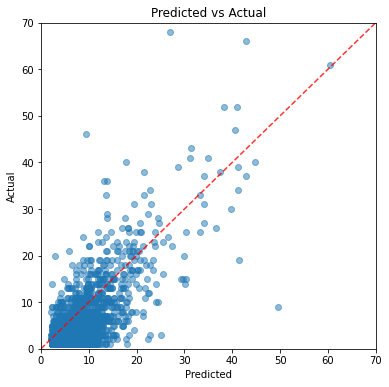

In [13]:
# scatter plot to compare actual and predicted values
plt.figure(figsize=(6,6))
plt.scatter(frequency_pred,frequency_actual,alpha=0.5)
plt.plot([0,100],[0,100],ls='--',C='r',alpha=0.8)
plt.xlim(0,70)
plt.ylim(0,70)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')
plt.show()

From the scatterplot output, we can see that the model’s predictions are decent.

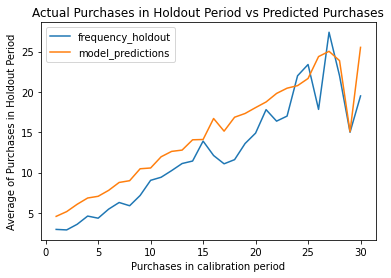

In [14]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

# plot calibration purchases vs holdout
plot_calibration_purchases_vs_holdout_purchases(bgf, returning_cal_holdout, n=30)

Above function groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). As we can see, despite our model not fitting the actual purchases perfectly, it was able to capture trends and significant turning points.

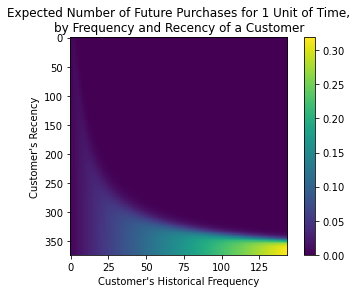

In [15]:
from lifetimes.plotting import plot_frequency_recency_matrix

# plot a heatmap of expected transactions in 1 day of time
plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 125 times, and their latest purchase was when they were 350 days old, then they are likely our best customers in the future (bottom-right).

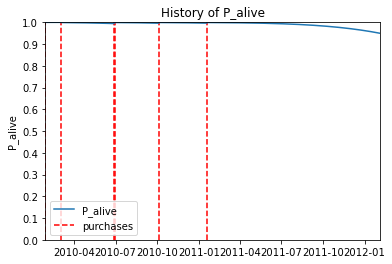

In [16]:
from lifetimes.plotting import plot_history_alive

# calculate historical probability of being alive for customer ID 12346
id = 12346
days_since_birth = 738
sp_trans = df[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

For each specific customer we can use above funtion to see the probability that he/she is 'alive' at certain point of time.

### Gamma-Gamma Model

For the second step, we will use the Gamma-Gamma submodel to predict the spend per transaction in the future at the customer level. This model relies on an important assumption that there is no relationship between the monetary value and the purchase frequency.

We'll check whether the Pearson correlation between the two features is close to 0 for the entire dataset and the calibration subset

In [17]:
# calculate the pearson correlation
print(returning_summary[['frequency', 'monetary_value']].corr())
print('\n')
print(returning_cal_holdout[['frequency_cal', 'monetary_value_cal']].corr())

                frequency  monetary_value
frequency        1.000000        0.175808
monetary_value   0.175808        1.000000


                    frequency_cal  monetary_value_cal
frequency_cal            1.000000            0.178972
monetary_value_cal       0.178972            1.000000


In [18]:
from lifetimes.fitters.gamma_gamma_fitter import GammaGammaFitter

monetary_actual = returning_cal_holdout['monetary_value_holdout']
params = [0, 0.001, 0.005, 0.01]
best_mse = 10000
best_param = None

# hyperparameter tuning using mean squared error as the scoring method
for penalizer_coef in params:
    ggf = GammaGammaFitter(penalizer_coef=penalizer_coef)
    ggf.fit(returning_cal_holdout['frequency_cal'],returning_cal_holdout['monetary_value_cal'])
    monetary_predicted = ggf.conditional_expected_average_profit(returning_cal_holdout['frequency_holdout'],
                                                             returning_cal_holdout['monetary_value_holdout'])
    mse = mean_squared_error(monetary_actual, monetary_predicted)
    if mse < best_mse:
        best_mse = mse
        best_param = penalizer_coef
    else:
        None

print(best_param, best_mse)

0.001 54.241957834359205


In [19]:
# train the model with the best parameter
ggf = GammaGammaFitter(penalizer_coef=best_param)
ggf.fit(returning_cal_holdout['frequency_cal'],returning_cal_holdout['monetary_value_cal'])

# predict the spend per transaction for the holdout days
monetary_predicted = ggf.conditional_expected_average_profit(returning_cal_holdout['frequency_holdout'],
                                                             returning_cal_holdout['monetary_value_holdout'])

#### Gamma-Gamma Model Evaluation

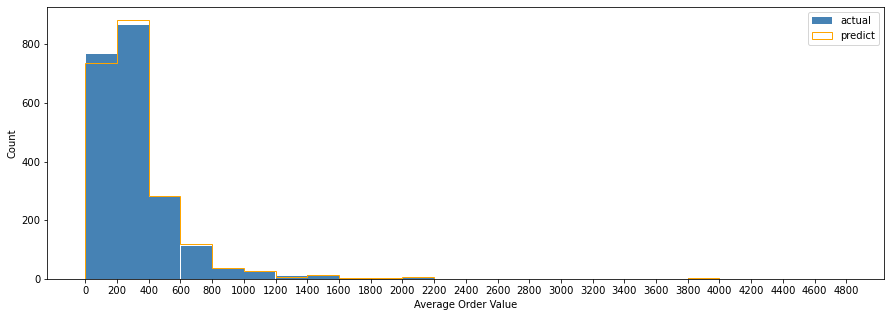

In [20]:
# histogram plot to compare predicted values and actual values
bins = np.arange(0,5000,200)
plt.figure(figsize=(15, 5))
plt.hist(monetary_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(monetary_predicted, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.xticks(np.arange(0,5000,200))
plt.xlabel('Average Order Value')
plt.ylabel('Count')
plt.legend(loc='upper right')

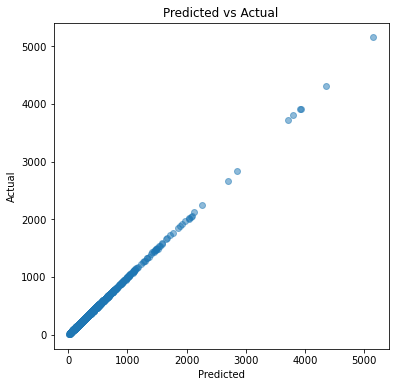

In [21]:
# scatter plot to compare predicted values and actual values
plt.figure(figsize=(6,6))
plt.scatter(monetary_predicted,monetary_actual,alpha=0.5)
# plt.plot([0,5000],[0,5000],ls='--',C='r',alpha=0.8)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')
plt.show()

### Customer LTV Prediction

This function will take the prediction of expected purchase and combine it with the expected purchase value. Together with the discount rate, these components allow us to arrive at an estimate of how much a customer is worth in a given period of time.

In [22]:
# predict the customer LTV for holdout days
clv_pred = ggf.customer_lifetime_value(bgf, #the model to predict the number of future transactions
                                  returning_cal_holdout['frequency_cal'],
                                  returning_cal_holdout['recency_cal'],
                                  returning_cal_holdout['T_cal'],
                                  returning_cal_holdout['monetary_value_cal'],
                                  time=12, # months
                                  discount_rate=0,
                                  freq='D'
                                 )

In [23]:
# predict the discounted customer LTV for holdout days 
clv_pred_discount = ggf.customer_lifetime_value(bgf, #the model to predict the number of future transactions
                                  returning_cal_holdout['frequency_cal'],
                                  returning_cal_holdout['recency_cal'],
                                  returning_cal_holdout['T_cal'],
                                  returning_cal_holdout['monetary_value_cal'],
                                  time=12, # months
                                  discount_rate=0.0025, #0.03/12 monthly discount rate ~ 3% annually
                                  freq='D'
                                 )

In [24]:
# assign the clv values
returning_cal_holdout['clv_pred'] = clv_pred
returning_cal_holdout['clv_pred_discount'] = clv_pred_discount
returning_cal_holdout = returning_cal_holdout.merge(clv_actual,how='left',on='CustomerID')

returning_cal_holdout.head()

,CustomerID,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,clv_pred,clv_pred_discount,clv_holdout
0,12347,1.0,37.0,39.0,711.79,6.0,599.701667,365.0,6217.197180,6117.457099,3598.21
1,12349,2.0,328.0,370.0,1110.57,1.0,1457.550000,365.0,3441.054512,3385.807063,1457.55
2,12352,1.0,17.0,27.0,200.05,7.0,115.037273,365.0,2019.494643,1987.100752,1265.41
3,12356,2.0,44.0,59.0,1162.93,3.0,829.143333,365.0,11573.456552,11387.803223,2487.43
4,12358,2.0,356.0,366.0,544.59,2.0,464.030000,365.0,1712.071997,1684.584127,928.06


#### Customer LTV Prediction Evaluation

In [25]:
# calculate the mean sqared error
clv_actual = returning_cal_holdout['clv_holdout']
mse = mean_squared_error(clv_actual, clv_pred)
print('MSE: {0}'.format(mse))

MSE: 28856564.1007977


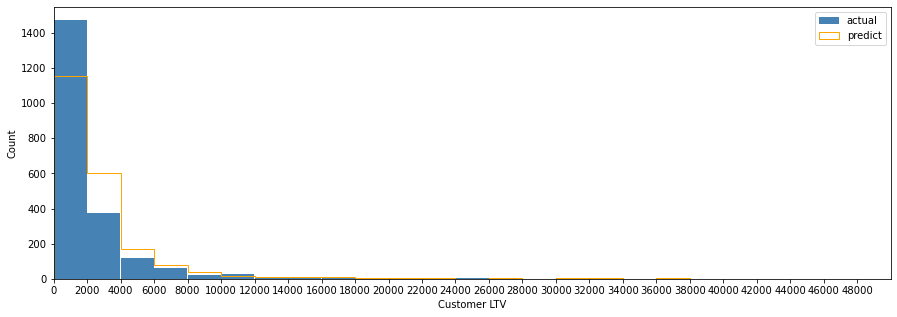

In [26]:
# histogram plot to compare predicted values and actual values
bins = np.arange(0,300000,2000)
plt.figure(figsize=(15, 5))
plt.hist(clv_actual, bins, label='actual', histtype='bar', color='STEELBLUE', rwidth=0.99)
plt.hist(clv_pred, bins, label='predict', histtype='step', color='ORANGE',  rwidth=0.99)
plt.xlim(0,50000)
plt.xticks(np.arange(0,50000,2000))
plt.xlabel('Customer LTV')
plt.ylabel('Count')
plt.legend(loc='upper right')

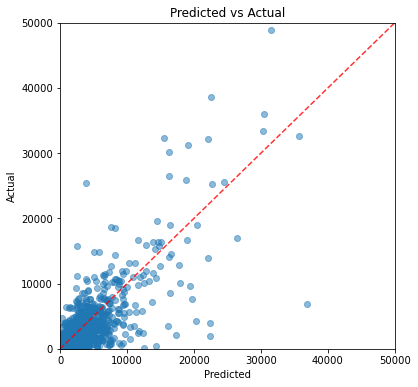

In [27]:
# scatter plot to compare predicted values and actual values
plt.figure(figsize=(6,6))
plt.scatter(clv_pred,clv_actual,alpha=0.5)
plt.plot([0,50000],[0,50000],ls='--',C='r',alpha=0.8)
plt.xlim(0,50000)
plt.ylim(0,50000)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Predicted vs Actual')
plt.show()

Now we can see the predicted top 10 most valued customers, and compare the prediction with the actual top 10 most valued customers:

In [28]:
# get the predicted top 10 customers and actual top 10 customers
top_10_pre = returning_cal_holdout[['CustomerID','clv_pred']].sort_values('clv_pred', ascending=False).head(10)
top_10 = returning_cal_holdout[['CustomerID', 'clv_holdout']].sort_values('clv_holdout', ascending=False).head(10)
top_10.merge(top_10_pre,on='CustomerID',how='outer')

,CustomerID,clv_holdout,clv_pred
0,14646,278466.02,193881.407591
1,18102,230518.12,276436.797121
2,17450,186231.73,NaN
3,14911,128047.15,108373.938863
4,12415,123638.18,NaN
5,14156,112899.89,145027.616410
6,17511,84733.19,68045.766614
7,16684,65892.08,64718.571262
8,13694,61848.42,102610.211679
9,15311,57978.51,42071.195950


### Conclusion

To conclude, we can see that eventhough the mean sqared error is high, the model was able to capture majority of the top 10 most valued customers, and only mispredicted 2 customers.

This model jointly models the probability to churn, purchase, and the average purchase value. It takes a few simple features, and is quite accurate when we look at the aggregated level.

### Next Steps

Due to it's simplicity, this model probably underfits the data and has inferior predictive performance compared to the more complex machine learning models. Additonally, it cannot take context data (e.g. customer demographics) into account, which also limits the predictive power of the model.

For the next steps of this project, there are some improvements we can make:
- Fit the model on customer cohorts (ex. split by user country).
- Join the model with a linear model with additional features (ex. a customer’s website visits, time since last visit, product reviews, channel of acquisition, etc.).